In [1]:
### EP3MAC0417/MAC5768
##################################################################
# AO PREENCHER ESSE CABEÇALHO COM O MEU NOME E O MEU NÚMERO USP, #
# DECLARO QUE SOU O ÚNICO AUTOR E RESPONSÁVEL PELA RESOLUÇÃO     #
# DESTE EP.                                                      #
# TODAS AS PARTES FORAM DESENVOLVIDAS E IMPLEMENTADAS POR MIM,   #
# SEGUINDO AS INSTRUÇÕES E QUE PORTANTO, NÃO CONSTITUEM          #
# DESONESTIDADE ACADÊMICA OU PLÁGIO.                             #
#                                                                #
# DECLARO TAMBÉM, QUE SOU RESPONSÁVEL POR TODAS AS CÓPIAS        #
# DESSE PROGRAMA, E QUE EU NÃO DISTRIBUI OU FACILITEI A          #
# SUA DISTRIBUIÇÃO. ESTOU CIENTE QUE OS CASOS DE PLÁGIO E        #
# DESONESTIDADE ACADÊMICA SERÃO TRATADOS SEGUNDO OS CRITÉRIOS    #
# DEFINIDOS NO CÓDIGO DE ÉTICA DA USP.                           #
#                                                                #
# ENTENDO QUE JUPYTER NOTEBOOKS SEM ASSINATURA NÃO SERÃO         #
# CORRIGIDOS E, AINDA ASSIM, PODERÃO SER PUNIDOS POR             #
# DESONESTIDADE ACADÊMICA.                                       #
#                                                                #
#                                                                #
# Nome: MARCUS VINICIUS FUGAGNOLI LARANJEIRA                     #
# NUSP: 5383459                                                  #
# Turma: MAC 0417/5768                                           #
# Prof.: Ronaldo Fumio Hashimoto                                 #
##################################################################

# EP 3 - Parte 3

Marcus Vinicius Fugagnoli Laranjeira - Número USP 5383459

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from skimage.measure import label, regionprops
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os

In [3]:
random_seed = 4447 

In [4]:
df = pd.read_csv('metadados_selecao_final_ep3.csv', sep=';', decimal=',', encoding='cp1252')

In [5]:
df

Classe  n_contorno   Área   Diâmetro     Minor  \
0           Lâmpada           0  250.5   6.586418  1.685623   
1    Chave de Fenda           1  168.5   3.236068  1.236068   
2            Pincel           2   98.0  27.016108  2.866696   
3           Lâmpada           0  121.5   7.492989  2.517998   
4           Cadeado           1   84.5   5.417868  3.167227   
..              ...         ...    ...        ...       ...   
802           Rolha           1   54.0   5.391920  1.427692   
803          Pincel           2   14.5   3.829708  1.885618   
804         Lâmpada           0  992.5  10.817213  2.968200   
805  Chave de Fenda           1  115.0   6.457484  2.816657   
806           Rolha           2   45.5  11.329344  2.642880   

                       Diretorio    Imagem  
0          .\originalGrayDataset  0011.png  
1          .\originalGrayDataset  0011.png  
2          .\originalGrayDataset  0011.png  
3          .\originalGrayDataset  0016.png  
4          .\originalGrayDataset  0016.png  
..                           ...       ...  
802  .\augmentedDataset\mean_img  0311.png  
803  .\augmentedDataset\mean_img  0311.png  
804  .\augmentedDataset\mean_img  0370.png  
805  .\augmentedDataset\mean_img  0370.png  
806  .\augmentedDataset\mean_img  0370.png  

[807 rows x 7 columns]

## Gráficos de Análise

### Gráfico 3D Área x Diâmetro x Minor Axis

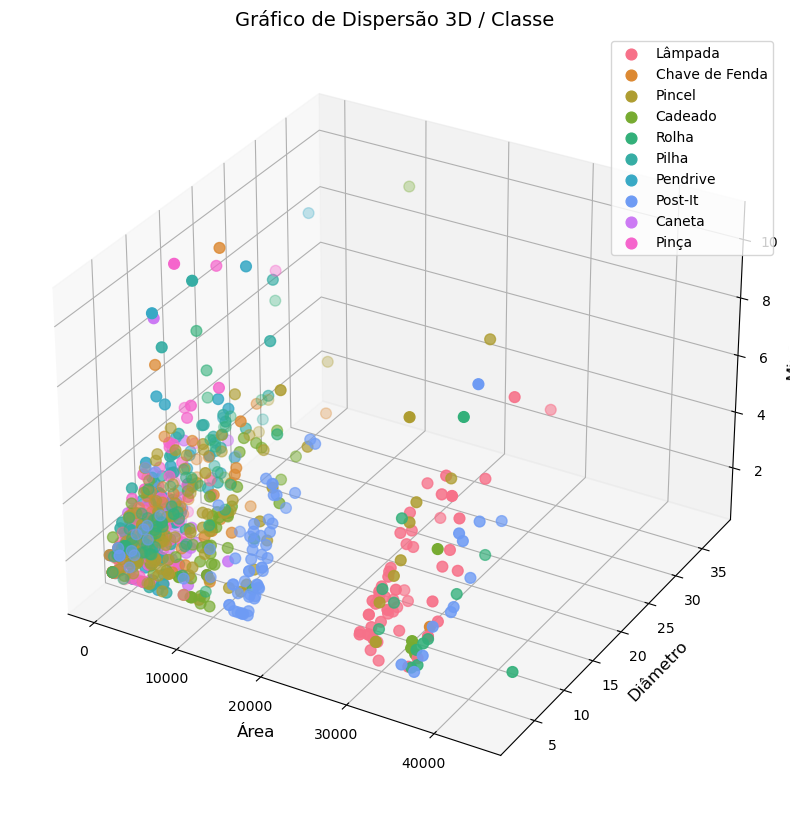

In [6]:
fig = plt.figure(figsize=(12, 10))  # Ajuste o tamanho conforme necessário
ax = fig.add_subplot(111, projection = '3d')

classes_unicas = df['Classe'].unique()
paleta_cores = sns.color_palette('husl', len(classes_unicas))

mapa_cores = {classe: cor for classe, cor in zip(classes_unicas, paleta_cores)}

for classe in classes_unicas:
    dados_classe = df[df['Classe'] == classe]

    ax.scatter(dados_classe['Área'], dados_classe['Diâmetro'], dados_classe['Minor'],
               color = [mapa_cores[classe]], label = classe, s = 60)

ax.set_xlabel('Área', fontsize = 12)
ax.set_ylabel('Diâmetro', fontsize = 12)
ax.set_zlabel('Minor', fontsize = 12)
ax.set_title('Gráfico de Dispersão 3D / Classe', fontsize = 14)
ax.legend()

plt.show()

### Gráficos 2D Área x Diâmetro | Área x Minor Axis | Diâmetro x Minor Axis

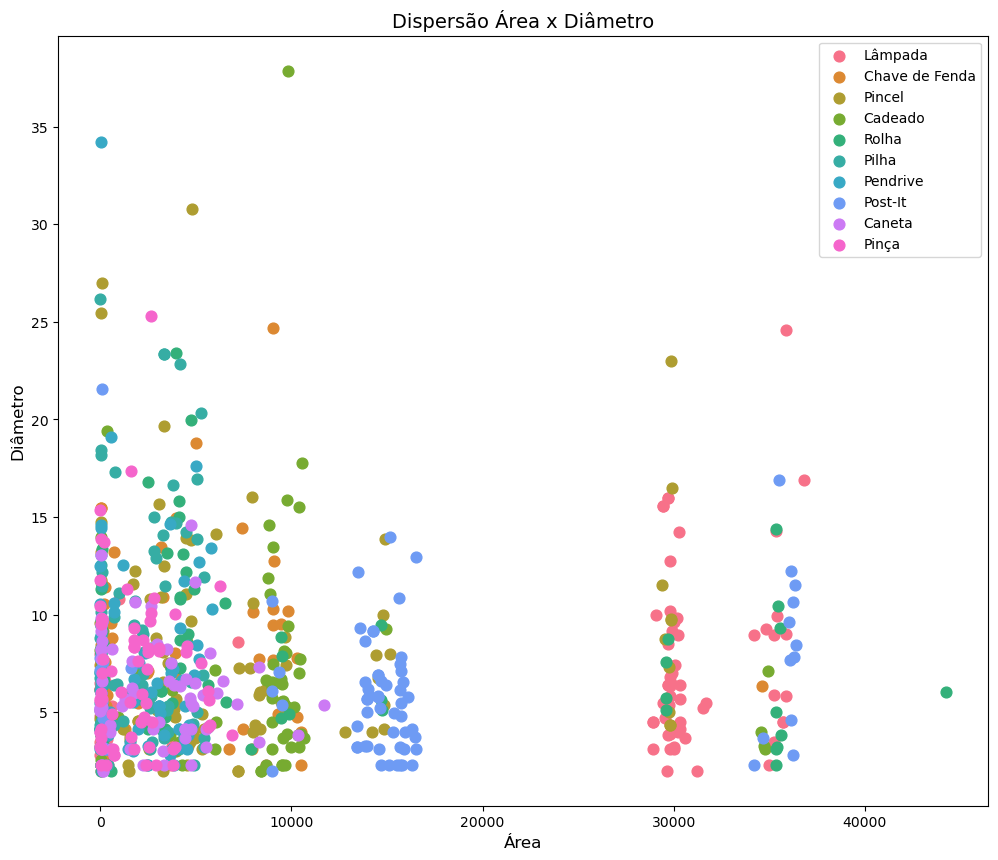

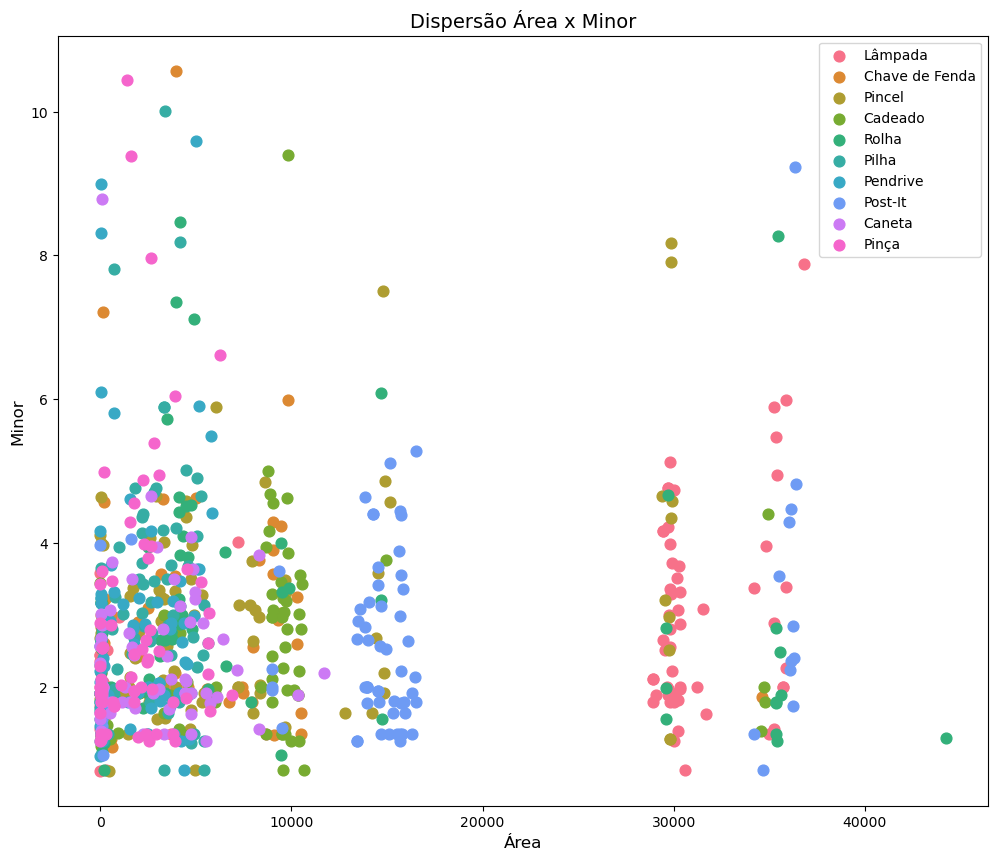

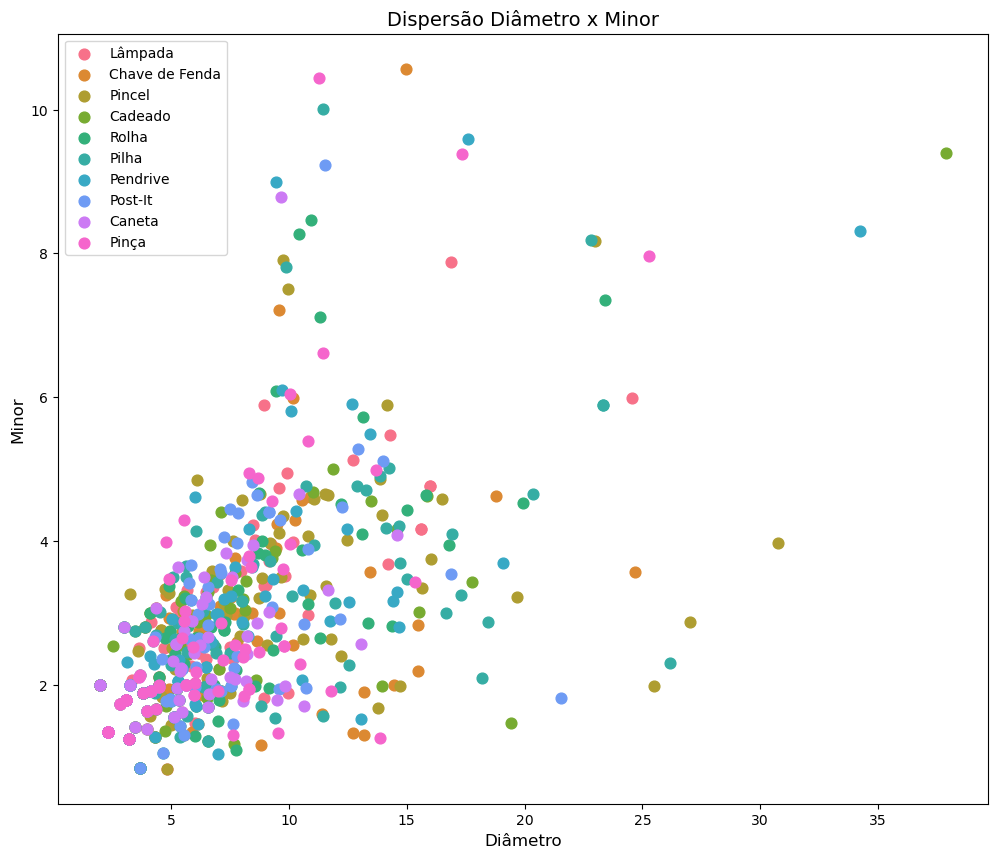

In [7]:
combinacoes = [
    ('Área', 'Diâmetro'),
    ('Área', 'Minor'),
    ('Diâmetro', 'Minor')
]

classes_unicas = df['Classe'].unique()
paleta_cores = sns.color_palette('husl', len(classes_unicas))

mapa_cores = {classe: cor for classe, cor in zip(classes_unicas, paleta_cores)}

for col1, col2 in combinacoes:
    plt.figure(figsize=(12, 10))  # Cria uma nova figura para cada gráfico

    for classe in classes_unicas:
        dados_classe = df[df['Classe'] == classe]

        plt.scatter(dados_classe[col1], dados_classe[col2], color = [mapa_cores[classe]], label = classe, s = 60)

    plt.xlabel(col1, fontsize=12)
    plt.ylabel(col2, fontsize=12)
    plt.title(f'Dispersão {col1} x {col2}', fontsize = 14)
    plt.legend()

    plt.show()

## Modelo de Classificação

In [8]:
# Separar as features e a target
X = df[['n_contorno', 'Área', 'Diâmetro', 'Minor']]
y = df['Classe']

In [9]:
# Normalizar os dados
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled.iloc[:, :-1] = scaler.fit_transform(X.iloc[:, :-1])

In [10]:
# Dividir os dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.15, random_state = random_seed)

In [11]:
# Criar o modelo Random Forest
rf_model = RandomForestClassifier(class_weight = 'balanced',
                                  max_depth = 100,
                                  min_samples_leaf = 2,
                                  n_estimators = 100,
                                  n_jobs = -1,
                                  random_state = random_seed)

In [12]:
# Treinar o modelo
rf_model.fit(X_train.iloc[:, :-1], y_train)

RandomForestClassifier(class_weight='balanced', max_depth=100,
                       min_samples_leaf=2, n_jobs=-1, random_state=4447)

In [13]:
# Fazer previsões no conjunto de teste
y_pred = rf_model.predict(X_test.iloc[:, :-1])

Acurácia: 0.5409836065573771
Relatório de Classificação:
                precision    recall  f1-score   support

       Cadeado       0.67      0.62      0.64        13
        Caneta       0.44      0.33      0.38        12
Chave de Fenda       0.50      0.55      0.52        11
       Lâmpada       0.92      0.71      0.80        17
      Pendrive       0.54      0.50      0.52        14
         Pilha       0.31      0.50      0.38        10
        Pincel       0.55      0.40      0.46        15
         Pinça       0.15      0.50      0.24         4
       Post-It       0.88      0.83      0.86        18
         Rolha       0.17      0.12      0.14         8

      accuracy                           0.54       122
     macro avg       0.51      0.51      0.49       122
  weighted avg       0.59      0.54      0.56       122



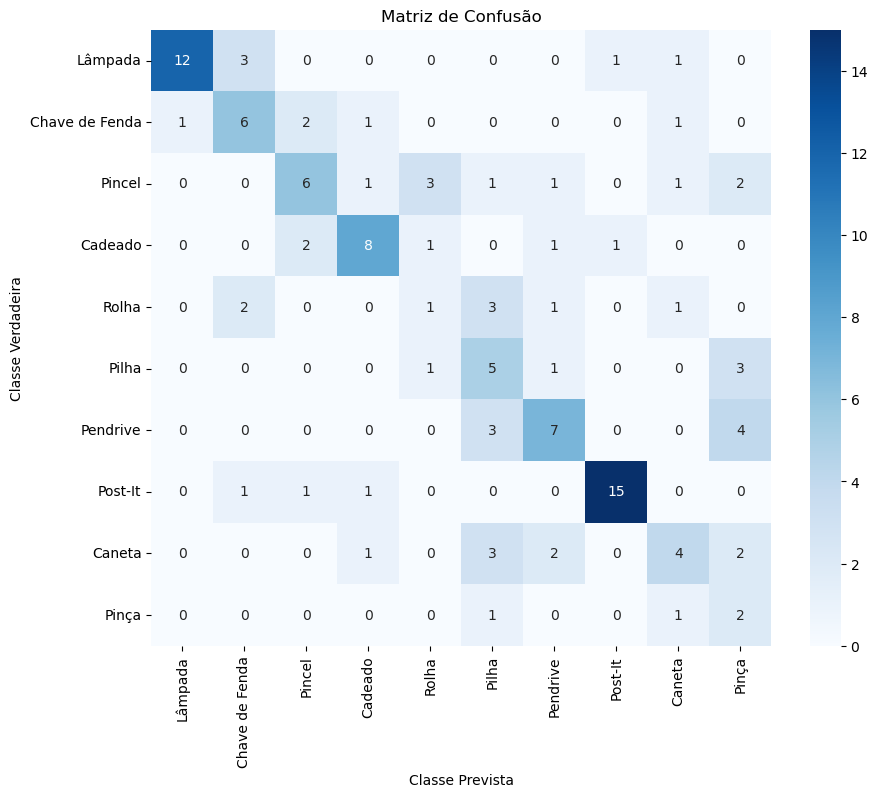

In [14]:
# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, labels=df['Classe'].unique())

print(f'Acurácia: {accuracy}')
print('Relatório de Classificação:')
print(report)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['Classe'].unique(), yticklabels=df['Classe'].unique())
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

A célula abaixo se for executada precisa atualizar a célula ao final deste notebook que mostra exemplos da classificação com desenho do retângulo ao redor do objeto identificado. Como sugestão, não execute, apenas verifique sua saída.

In [15]:
# Selecionar 3 amostras aleatórias do conjunto de teste
random_indices = np.random.choice(X_test.index, 3, replace=False)
sample_data = X_test.loc[random_indices]

# Fazer previsões nas amostras selecionadas
sample_predictions = rf_model.predict(sample_data.iloc[:, :-1])

# Mostrar os dados originais e as predições
for i, index in enumerate(random_indices):
    original_data = df.loc[index]
    print(f"Original Data (index {index}):")
    print(original_data)
    print(f"Predicted Class: {sample_predictions[i]}")
    print(f"True Class: {y_test.loc[index]}")
    print("\n")


Original Data (index 594):
Classe                                 Post-It
n_contorno                                   0
Área                                   15910.5
Diâmetro                              3.098387
Minor                                 1.788854
Diretorio     .\augmentedDataset\log_transform
Imagem                                0168.png
Name: 594, dtype: object
Predicted Class: Post-It
True Class: Post-It


Original Data (index 201):
Classe                                       Cadeado
n_contorno                                         0
Área                                            38.0
Diâmetro                                    6.052283
Minor                                        1.69589
Diretorio     .\augmentedDataset\contrast_stretching
Imagem                                      0100.png
Name: 201, dtype: object
Predicted Class: Post-It
True Class: Cadeado


Original Data (index 267):
Classe                                       Post-It
n_contorno            

In [16]:
def processar_imagem(imagem_path):
    """Processa imagem efetuando:
        - suavização com Gaussian Blur e detecção de bordas
        - cálculo da área dos contornos encontrados
        - traço dos contornos
         
    Parameters
    ----------
        None
    Returns
    -------
        Imagem processada, áreas e propriedades dos contornos
    """
    # Carregar a imagem
    imagem = cv2.imread(imagem_path, cv2.IMREAD_GRAYSCALE)
    
    # Verificar se a imagem foi carregada corretamente
    if imagem is None:
        print(f"Erro ao carregar a imagem: {imagem_path}")
        return None, [], []

    # 1. Suavização com Gaussian Blur e detecção de bordas
    imagem_suavizada = deteccao_bordas_gradiente(imagem, tipo_kernel = 'sobel', limiar = 0.15, dim_kernel = 7)

    # 2. Traçar contornos
    contornos, _ = cv2.findContours(imagem_suavizada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 3. Calcular e armazenar a área de cada contorno
    areas = [cv2.contourArea(c) for c in contornos]

    # 4. Traçar apenas os 3 maiores contornos
    maiores_contornos = sorted(contornos, key=cv2.contourArea, reverse=True)[:3]
    imagem_contornada = cv2.cvtColor(imagem, cv2.COLOR_GRAY2BGR)  # Convertendo para BGR para desenhar contornos coloridos
    cv2.drawContours(imagem_contornada, maiores_contornos, -1, (255, 0, 0), 1)

    # Convertendo imagem_contornada para colorida
    imagem_contornada_colorida = cv2.cvtColor(imagem_contornada, cv2.COLOR_BGR2RGB)
    
    # Rótulo a imagem original com contornos desenhados para análise de propriedades
    label_img = label(imagem_suavizada, connectivity=2)
    props = regionprops(label_img)

    # Filtrar props com base nas áreas dos maiores contornos
    props_filtradas = [prop for prop in props if prop.area in areas]
    props_img = props_filtradas

    return imagem_contornada_colorida, areas, props_img, contornos

In [17]:
def deteccao_bordas_gradiente(imagem, tipo_kernel = 'sobel', limiar = 0.33, dim_kernel = 3):
    """Detecta bordas em uma imagem usando o gradiente.
    
    Parameters
    ----------
        tipo_kernel (str: Tipo de Kernel à ser utilizado, prewitt ou sobel. Default: sobel
        limiar (float): limiar para o Thresholding. Defaul 0.33
        dim_kernel (int): dimensão (quadrada) do kernel. Default: 3 (3x3)
    Returns
    -------
        numpy.ndarray: A imagem convertida em tons de cinza.
    """

    # Passo 1: Suavizar a imagem (opcional, dependendo do nível de ruído)
    imagem_suavizada = cv2.GaussianBlur(imagem, (dim_kernel, dim_kernel), 2.5)  # Suavização Gaussiana

    # Passo 2: Calcular a magnitude do gradiente
    if tipo_kernel == 'sobel':
        gx = cv2.Sobel(imagem_suavizada, cv2.CV_64F, 1, 0, ksize = dim_kernel)
        gy = cv2.Sobel(imagem_suavizada, cv2.CV_64F, 0, 1, ksize = dim_kernel)
    elif tipo_kernel == 'prewitt':
        gx = cv2.Sobel(imagem_suavizada, cv2.CV_64F, 1, 0, ksize = dim_kernel, scale = 1, delta = 0, borderType = cv2.BORDER_DEFAULT)
        gy = cv2.Sobel(imagem_suavizada, cv2.CV_64F, 0, 1, ksize = dim_kernel, scale = 1, delta = 0, borderType = cv2.BORDER_DEFAULT)
    else:
        raise ValueError("Tipo de kernel inválido. Escolha 'sobel' ou 'prewitt'.")

    magnitude = np.sqrt(gx ** 2 + gy **2)
    magnitude = magnitude / np.max(magnitude)  # Normalizar para o intervalo [0, 1]

    # Passo 3: Limiarizar a magnitude do gradiente
    limiar_absoluto = limiar * np.max(magnitude)
    imagem_bordas = (magnitude >= limiar_absoluto).astype(np.uint8) * 255

    return imagem_bordas

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


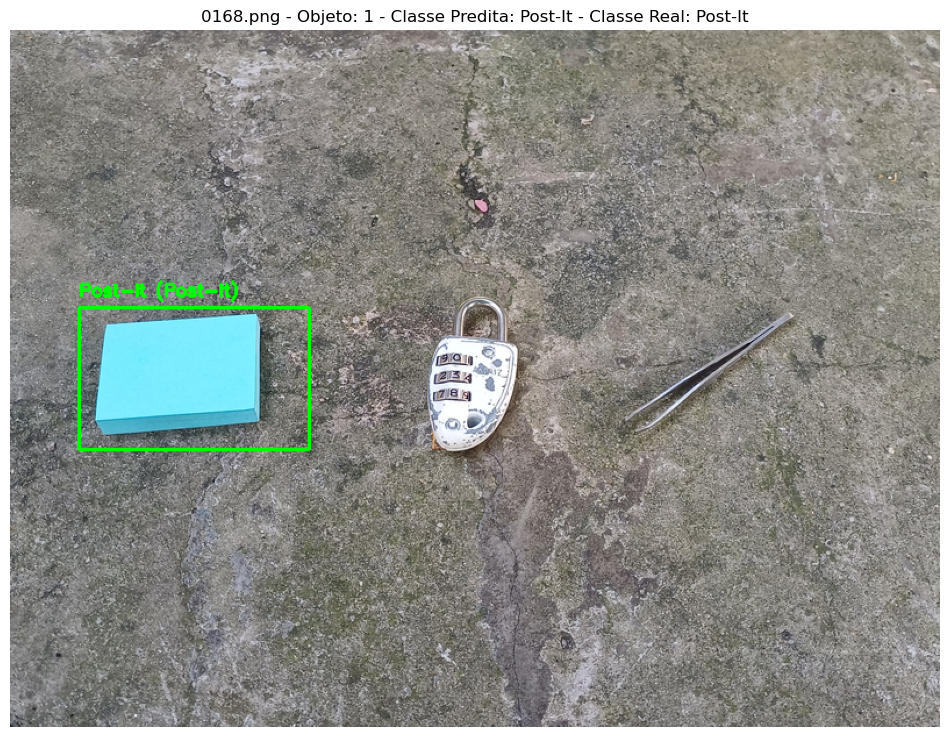

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagem: .\augmentedDataset\log_transform\0168.png - Área: 15910.5, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\log_transform\0168.png - Área: 9786.0, Diâmetro: 3.885753375057407, Menor: 2.7954428906961324
Imagem: .\augmentedDataset\log_transform\0168.png - Área: 2702.0, Diâmetro: 4.505936460652527, Menor: 1.964637859424638


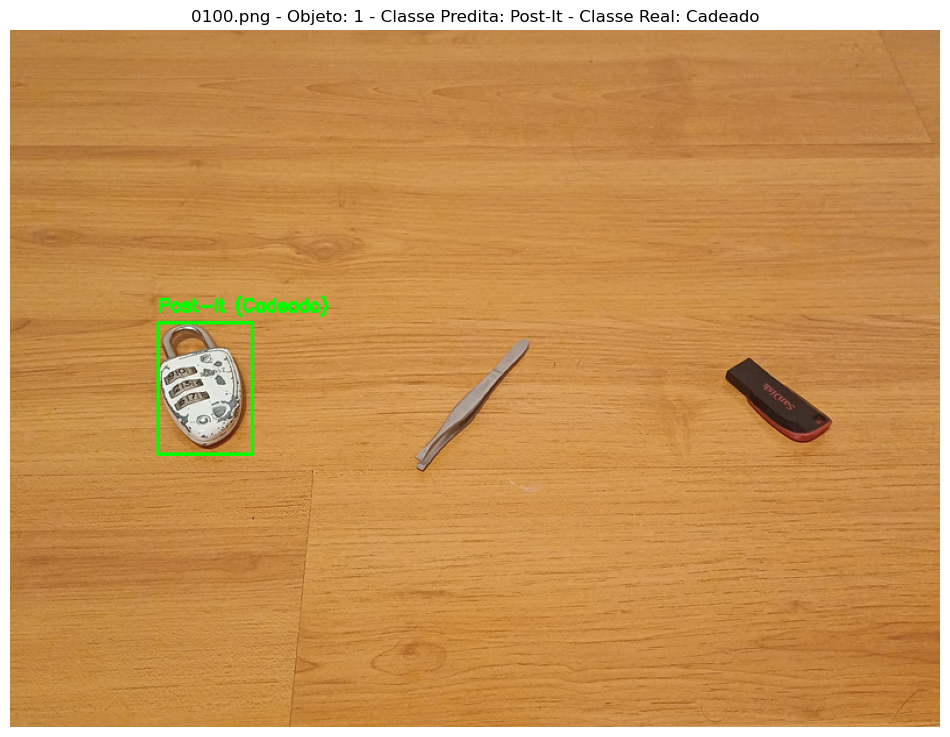

Imagem: .\augmentedDataset\contrast_stretching\0100.png - Área: 38.0, Diâmetro: 6.052283110938236, Menor: 1.695889732428958
Imagem: .\augmentedDataset\contrast_stretching\0100.png - Área: 16.5, Diâmetro: 9.529675494243438, Menor: 1.3218428217796863
Imagem: .\augmentedDataset\contrast_stretching\0100.png - Área: 15.0, Diâmetro: 13.073253969622831, Menor: 1.522070074736227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


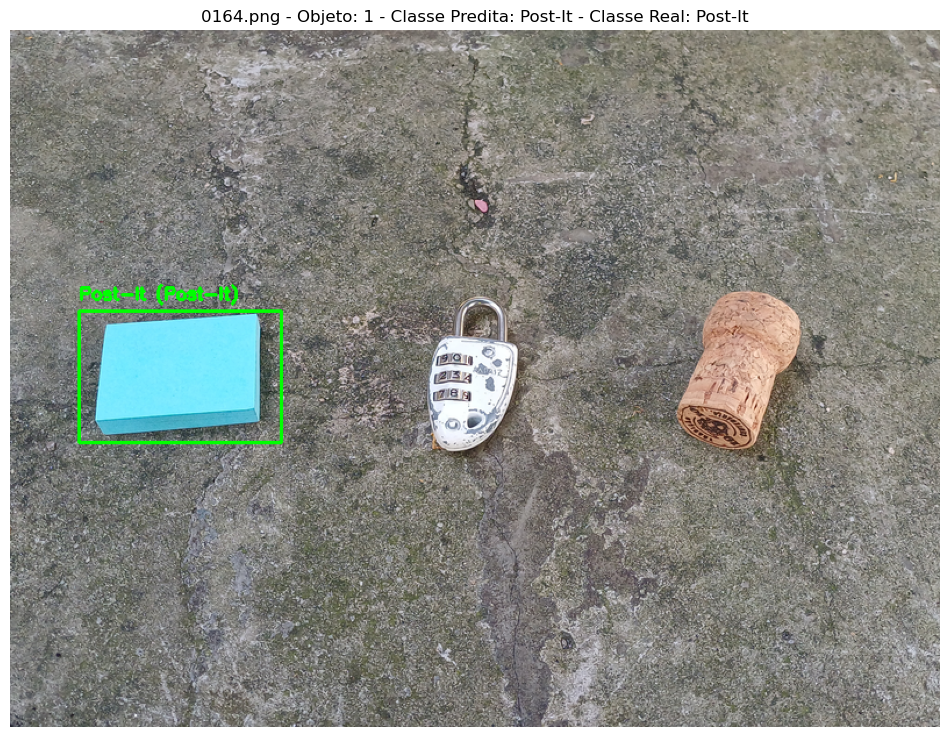

Imagem: .\augmentedDataset\contrast_stretching\0164.png - Área: 14534.0, Diâmetro: 5.754986301390788, Menor: 3.417620908000825
Imagem: .\augmentedDataset\contrast_stretching\0164.png - Área: 9980.5, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898
Imagem: .\augmentedDataset\contrast_stretching\0164.png - Área: 4110.0, Diâmetro: 6.491432935357954, Menor: 3.2157889305347775


In [18]:
imagens = [{'caminho': '.\\augmentedDataset\\log_transform\\0168.png', 'n_contorno': 0, 'predito': 'Post-It', 'real':'Post-It'},
           {'caminho': '.\\augmentedDataset\\contrast_stretching\\0100.png', 'n_contorno': 0, 'predito':'Post-It', 'real':'Cadeado'},
           {'caminho': '.\\augmentedDataset\\contrast_stretching\\0164.png', 'n_contorno': 0, 'predito':'Post-It', 'real':'Post-It'}]
# Lista para armazenar todas as áreas e propriedades
todas_areas = []
todas_props = []

# Lista para armazenar dados para o CSV
dados_csv = []

# Processar cada imagem
for imagem in imagens:
    imagem_path = imagem['caminho']
    imagem_processada, areas, props_img, contornos = processar_imagem(imagem_path)
    todas_areas.append(areas)
    todas_props.append(props_img)

    diretorio, nome_arquivo = os.path.split(imagem_path)
    imagem_original_path = '.\\imagens\\' + nome_arquivo
    imagem_original = mpimg.imread(imagem_original_path)
    # Mostrar a imagem processada
#     plt.figure(figsize=(12, 10))
#     plt.imshow(imagem_original)
#     plt.title(nome_arquivo + f' - Objeto: {imagem["n_contorno"] + 1} - Classe Predita: {imagem["predito"]} - Classe Real: {imagem["real"]}')
#     plt.axis('off')
#     plt.show()
#     plt.close()

    # Ordenar contornos por área (decrescente)
    contornos_ordenados = sorted(contornos, key=cv2.contourArea, reverse=True)

    # Pegar os 3 maiores contornos
    maiores_contornos = contornos_ordenados[:3]
    
    # Escolher o contorno de interesse (0, 1 ou 2 para os 3 maiores)
    n_contorno = imagem['n_contorno']
    if n_contorno < len(maiores_contornos):  # Verificar se o contorno existe
        contorno_escolhido = maiores_contornos[n_contorno]
        x, y, w, h = cv2.boundingRect(contorno_escolhido)
        cv2.rectangle(imagem_original, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Verde
        cv2.putText(imagem_original, f'{imagem["predito"]} ({imagem["real"]})', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Mostrar a imagem original com retângulo e texto
    plt.figure(figsize=(12, 10))
    plt.imshow(imagem_original)
    plt.title(nome_arquivo + f' - Objeto: {imagem["n_contorno"] + 1} - Classe Predita: {imagem["predito"]} - Classe Real: {imagem["real"]}')
    plt.axis('off')
    plt.show()
    plt.close()
    
    # Ordenar áreas e props_img com base nas áreas dos contornos
    areas_props_sorted = sorted(zip(areas, props_img), key=lambda x: x[0], reverse=True)

    # Pegar as três maiores áreas e suas respectivas propriedades
    maiores_areas_props = areas_props_sorted[:3]

    # Garantir que tenhamos exatamente 3 entradas, preenchendo com valores vazios, se necessário
    while len(maiores_areas_props) < 3:
        maiores_areas_props.append((None, None))

    # Para cada uma das três maiores áreas, recuperar diâmetro e menor eixo
    for idx, (area, prop) in enumerate(maiores_areas_props):
        if area is not None and prop is not None:
            try:
                diameter = prop.major_axis_length  # Supondo que você queira o diâmetro
                minor_axis = prop.minor_axis_length  # Supondo que você queira o menor eixo
            except ValueError as e:
                print(f"Erro ao calcular propriedades: {e}")
                diameter = None
                minor_axis = None
        else:
            area = ''
            diameter = ''
            minor_axis = ''
       
        
        # Imprimir os dados
        print(f"Imagem: {imagem_path} - Área: {area}, Diâmetro: {diameter}, Menor: {minor_axis}")


## Conclusão

Neste trabalho, foi desenvolvido um classificador multi-classe utilizando técnicas de processamento de imagens, detecção de borda com Sobel, suavização com Gaussian Blur, e extração de características dos contornos obtidos para então alimentar um modelo de Random Forest. A acurácia do classificador, entretanto, foi de aproximadamente 55%, um resultado insatisfatório.

A análise dos resultados confrontando as imagens com contornos obtidas indica que a baixa acurácia foi influenciada diretamente pelas condições nas quais as fotos foram tiradas, com fundos ruidosos e sombras que afetaram significativamente a detecção de bordas. Observou-se que as técnicas utilizadas poderiam ter sido mais eficazes caso o fundo das imagens fosse neutro e oferecesse contraste suficiente para uma detecção de borda mais precisa.

Ressalta-se que a escolha das técnicas de processamento de imagem, como laplaciano, logaritmo, exponencial, contrast stretching e equalização de histograma utilizadas ao longo do trabalho, são importantes e sua utilização deve considerar tanto o objetivo quanto a qualidade e as condições de aquisição das imagens. A melhoria na acurácia do classificador pode ser alcançada através da otimização das condições de captura das imagens e da seleção apropriada das técnicas de processamento, garantindo que o contraste e a qualidade das imagens sejam adequados para uma análise mais eficiente.

### FIM EP3 - Parte 3

<hr style="border: 0; border-top: 10px solid black; width: 85%; margin: 0 auto;">